# All Businesses in Philadelphia

This notebook uses a list of gay words (created in the NLP notebook from existing gay business reviews) to find other gay business that are not tagged as such. 

I will bring in the dataframe that contains all reviews for Philadelphia (Created in Process Yelp) and count the number of times each gay word appears in a business' reviews. 

The output of this notebook is a list of Yelp Business IDs of our newly identified queer businesses. I'll take that list into our final notebook to analyze those businesses through mapping and inspecting other attributes. 

In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import ngrams, FreqDist

import re
nltk.download('stopwords')
nltk.download('punkt')

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/harper/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Create newgayDf
Create a dataframe that identifies businesses with gay words.

First, I'll bring in the reviews. Then, I want to create a dataframe where the index is the business_id and each row is all the reviews smashed together. Essentially, there is one bag of reviews for each business. Next, I'll clean each of the review bags to remove whitespaces and other characters and make lowercase. I'll also need to tokenize so I can count words in the next step.


<div class="alert alert-block alert-danger">
Don't rerun this! Just use the saved pickle. 
</div>

In [ ]:
# bring in all reviews in philadelphia
reviews = pd.read_pickle('data/reviewsPhil.pandas')

# standardize the reviews text
reviews['text'] = reviews['text'].fillna('').astype(str)

# group by business_id and sum
bizDf = reviews.groupby('business_id')['text'].sum().to_frame()

In [ ]:
# Create function to clean and count

def FindNewGays(in_df):
    
    # clean all the text and tokenize
    df = in_df.text.apply(lambda item: item.lower()).apply(lambda item: word_tokenize(re.sub(r"[^A-z\s]", "", item))).to_frame()
    
    # remove stopwords
    df['text'] = df['text'].apply(lambda review: [word for word in review if (word not in mystop)])

    # make column with gay words extracted
    df['gay_text'] = df['text'].apply(lambda review: [word for word in review if (word in gay_words)])

    # create new dataframe only with businesses that have at least one gay word in the reviews
    newgayDf = df[df['gay_text'].apply(lambda x: len(x) >0)].copy()

    # count number of words for each business and sort
    newgayDf['gay_text_len'] = newgayDf.gay_text.apply(lambda x: len(x))
    newgayDf.sort_values('gay_text_len', ascending=False, inplace=True)

    # create frequency distribution of gay words for each business
    newgayDf['gay_counts'] = newgayDf['gay_text'].apply(lambda words: Counter(words))

    # count unique gay words for each business
    newgayDf['gay_unique_count'] = newgayDf['gay_counts'].apply(lambda freq: len(freq.keys()))

    return newgayDf


In [ ]:
# Run function and create newgaybiz.pandas
gay_words = ['gay','drag','queen','queer','queens','lgbt','bear','lesbian','gays','lgbtq','homophobic','bears','trans','lesbians','transgender','dyke','twinks','queers','homosexual','bisexual','homosexuals']
mystop = stopwords.words('english')

newgayDf = FindNewGays(bizDf)

newgayDf.to_pickle('data/newgaybiz.pandas')

# Clean up newgayDf

In [65]:
# read in pickle
newgayDf = pd.read_pickle('data/newgaybiz.pandas')

In [66]:
# drop text column for size
newgayDf = newgayDf.drop(columns = ['text'])

In [67]:
# make index a column
newgayDf.reset_index(inplace=True)
newgayDf = newgayDf.rename(columns = {'index':'business_id'})

In [68]:
# flag gay businesses we already identified
known_gay = pd.read_csv('data/philly_gay_businesses.csv')
newgayDf['known'] = newgayDf.business_id.isin(known_gay.business_id)

In [69]:
print(newgayDf.groupby('known').size())
print(len(known_gay))

known
False    4879
True       28
dtype: int64
45


Interesting... only 28 our our 45 known gay businesses were picked up using our NLP! While we will pick up new businesses with this method, certainly not all queer identified businesses will be included.


Now I want to remove businesses that don't have a significant number of hits. I'll make a histogram to choose the cut off. From the plot and the frequency table, the biggest group is gay_text_len = 1. I'll drop that. Furthermore, the biggest drop-off is at gay_text_len = 5. I will inspect those items and considering dropping them in the future if they are false hits. 

array([[<AxesSubplot:title={'center':'gay_text_len'}>]], dtype=object)

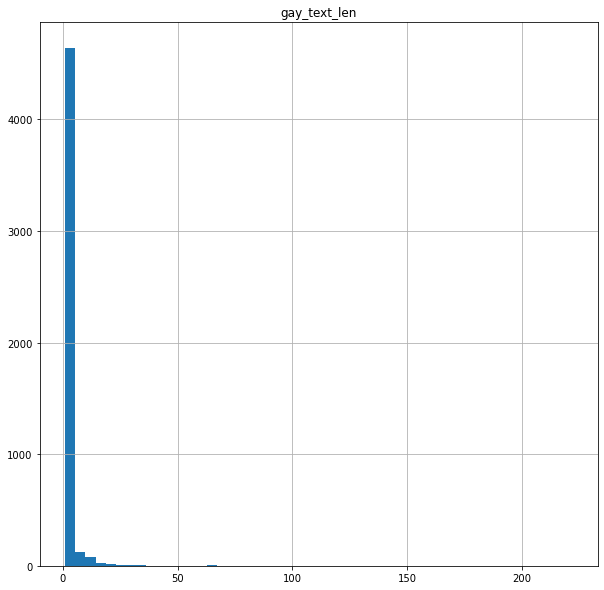

In [70]:
# make histogram of gay_text_len
newgayDf.hist(column = 'gay_text_len', figsize = (10,10), bins = 50)

In [71]:
newgayDf.groupby('gay_text_len').size().head(15)

gay_text_len
1     3188
2      836
3      317
4      187
5      109
6       47
7       29
8       24
9       25
10      22
11      11
12      13
13      17
14      12
15       8
dtype: int64

In [72]:
newgayDf = newgayDf[newgayDf.gay_text_len > 1]
len(newgayDf)

1719

In [73]:
newgayDf.to_pickle('data/newgaybiz_clean.pandas')

## Test on a Slice
Experiment with code to run on the big massive review df

In [ ]:
gay_words = ['gay','drag','queen','queer','queens','lgbt','bear','lesbian','gays','lgbtq','homophobic','bears','trans','lesbians','transgender','dyke','twinks','queers','homosexual','bisexual','homosexuals']

In [ ]:
# make a slice
sliceDf = bizDf.head(1000).copy()

In [ ]:
# clean up the text and tokenize
sliceDf = sliceDf.text.apply(lambda item: item.lower()).apply(lambda item: word_tokenize(re.sub(r"[^A-z\s]", "", item))).to_frame()

In [ ]:
# remove stopwords
mystop = stopwords.words('english')
sliceDf['text'] = sliceDf['text'].apply(lambda review: [word for word in review if (word not in mystop)])

In [ ]:
# extract gay words into new column
sliceDf['gay_text'] = sliceDf['text'].apply(lambda review: [word for word in review if (word in gay_words)])
sliceDf

In [ ]:
# subset for businesses with gay words
newgayDf = sliceDf[sliceDf['gay_text'].apply(lambda x: len(x) >0)].copy()

In [ ]:
newgayDf

In [ ]:
# Just count the number of words that were identified. This can be used later to screen out some businesses
newgayDf['gay_text_len'] = newgayDf.gay_text.apply(lambda x: len(x))
newgayDf.sort_values('gay_text_len', ascending=False, inplace=True)
newgayDf

In [ ]:
# create frequency distribution of gay words for each business 
newgayDf['gay_counts'] = newgayDf['gay_text'].apply(lambda words: Counter(words))
newgayDf

In [ ]:
# count unique gay words for each business
newgayDf['gay_unique_count'] = newgayDf['gay_counts'].apply(lambda freq: len(freq.keys()))
newgayDf

## Future Tasks

- Drop words that are getting false hits (like bear and drag)
- Drop businesses with a few hits
- Do manual check of what those businesses are (will need to join newgayDf back to bizPhil)
- Get frequency of summation of all gay words
- Do ngrams on text and gay text? 
- flag our previously identified businesses
